# Tutorial: Predictive Uncertainty & Dirichlet Prior Networks (DPN)

Welcome!  
This notebook teaches you the fundamentals of predictive uncertainty and Dirichlet Prior Networks (DPNs).

By the end of this tutorial, you will know how to:

- understand uncertainty types  
- build a DPN from scratch  
- train it with in-domain and OOD data  
- compute and visualize uncertainty  
- evaluate OOD detection performance  


# 1. Motivation: Why Uncertainty Matters

Conventional neural networks are often *overconfident*.  
They output strong softmax probabilities even when the input is noisy, ambiguous, or completely out-of-distribution (OOD).

Example:

A blurry handwritten "3" might get a prediction like:

**“99.9% confident this is a 3.”**

Clearly, the model *should* be unsure.


## 1.1 Types of Uncertainty

Neural networks face three major types of uncertainty:

| Type | Meaning | Example |
|------|---------|---------|
| **Aleatoric** | Noise or ambiguity in the data | Blurry digit |
| **Epistemic** | Model uncertainty due to missing knowledge | Unfamiliar shapes |
| **Distributional (OOD)** | Input comes from a different dataset entirely | Clothing image for a digit classifier |

Dirichlet Prior Networks focus mainly on **distributional uncertainty**, but they help with all three types.


# 2. The Idea: Distributions Over Distributions

A classical classifier outputs **one softmax distribution**.

A Dirichlet Prior Network (DPN), however, outputs the **parameters of a Dirichlet distribution**, which is a distribution *over* possible softmax distributions.

This gives the model the ability to express:

- **high certainty** (sharp Dirichlet, high precision α₀)  
- **uncertainty / OOD** (flat Dirichlet, low precision α₀)

This is a more expressive form of uncertainty than plain softmax.


# 3. Setup

We start by importing libraries and checking device availability.


In [ ]:
# Import core PyTorch modules needed to build neural networks.
import matplotlib.pyplot as plt

# Standard Python libs for arrays and plotting.
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Data loading utilities for batching and shuffling datasets.
from torch.utils.data import DataLoader

# torchvision gives us MNIST and Fashion-MNIST built in.
from torchvision import datasets, transforms

# Choose GPU if available; otherwise fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display the device being used.
device

device(type='cpu')

# 4. Loading the Datasets

To train a Dirichlet Prior Network, we need:

- **In-domain data** → MNIST (handwritten digits)
- **Out-of-distribution data (OOD)** → Fashion-MNIST (clothing images)

The DPN learns to be **confident** on MNIST and **uncertain** on Fashion-MNIST.


In [ ]:
# Define how images should be transformed:
# - Convert to PyTorch tensor
# - Normalize pixel values from [0,1] to approximately [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST training/test datasets (in-domain data).
mnist_train = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transform,
)
mnist_test = datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=transform,
)

# Load Fashion-MNIST training/test datasets (OOD data).
fmnist_train = datasets.FashionMNIST(
    "./data",
    train=True,
    download=True,
    transform=transform,
)
fmnist_test = datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transform,
)

# Size of mini-batches during training.
batch_size = 128

# Create data loaders that return batches of image/label pairs.
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

fmnist_train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
fmnist_test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.71MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 9.80MB/s]
100%|██████████| 29.5k/29.5k [00:00<?, ?B/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 9.37MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 1.03MB/s]


## 4.1 Visualizing the Data

Before training, let's take a quick look at some samples from each dataset.

This helps us understand why Fashion-MNIST counts as “out of distribution” for a digit classifier.

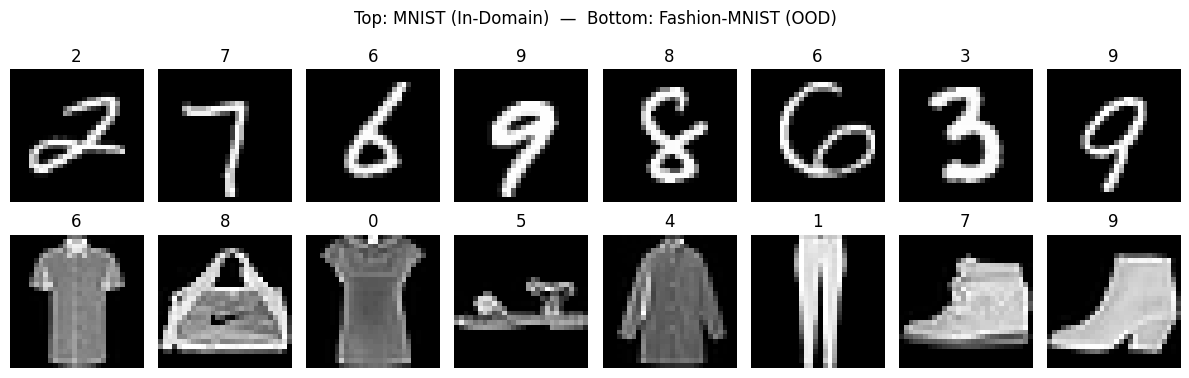

In [4]:
# Take a single batch from each loader.
images_mnist, labels_mnist = next(iter(mnist_train_loader))
images_fmnist, labels_fmnist = next(iter(fmnist_train_loader))

# Create a figure with 2 rows and 8 columns of images.
fig, axes = plt.subplots(2, 8, figsize=(12, 4))

# Show 8 MNIST images on the first row.
for i in range(8):
    axes[0, i].imshow(images_mnist[i, 0], cmap="gray")
    axes[0, i].set_title(labels_mnist[i].item())
    axes[0, i].axis("off")

# Show 8 Fashion-MNIST images on the second row.
for i in range(8):
    axes[1, i].imshow(images_fmnist[i, 0], cmap="gray")
    axes[1, i].set_title(labels_fmnist[i].item())
    axes[1, i].axis("off")

# Add a title above both rows.
plt.suptitle("Top: MNIST (In-Domain)  —  Bottom: Fashion-MNIST (OOD)")

# Adjust spacing so the plot looks neat.
plt.tight_layout()

plt.show()

# 5. Building the Dirichlet Prior Network (DPN)

A DPN outputs **Dirichlet concentration parameters** instead of softmax probabilities.

These parameters (α values):

- must be **positive**
- reflect **confidence** (high α₀)
- reflect **uncertainty / OOD** (low α₀)

We build a simple CNN that outputs 10 α-values (for 10 classes).


In [ ]:
class ConvDPN(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        """Initialize the ConvDPN model with the given number of classes."""
        super().__init__()

        # CNN feature extractor:
        # - Conv layer (1→32 channels)
        # - ReLU activation
        # - MaxPool to shrink spatial size by 2
        # Repeat pattern for deeper feature extraction.
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 → 14x14
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 → 7x7
        )

        # Classifier head:
        # - Flatten feature maps
        # - Linear hidden layer with 128 neurons
        # - Final linear layer produces 10 outputs (RAW logits)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),  # no softmax!
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Run a forward pass through the ConvDPN model.

        Parameters
        ----------
        x : torch.Tensor
        Input image batch of shape (B, 1, 28, 28).

        Returns:
        -------
        torch.Tensor
        Dirichlet concentration parameters α of shape (B, num_classes).
        """  # noqa: RUF002
        # Extract features using convolution layers.
        x = self.features(x)

        # Compute raw logits from fully connected layers.
        logits = self.classifier(x)

        # Convert logits to positive Dirichlet α-values.  # noqa: RUF003
        # Softplus = log(1 + exp(x)), always > 0.  # noqa: ERA001
        alpha = F.softplus(logits) + 1e-3
        return alpha


# Create model and send it to GPU/CPU.
model = ConvDPN().to(device)
model

ConvDPN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

# 6. Helper Functions for Dirichlet Distributions

We now implement:
- KL divergence between Dirichlet distributions
- Predictive probabilities
- Predictive entropy
- Dirichlet differential entropy

These are required for training and evaluating a DPN.

In [ ]:
from torch.special import digamma, gammaln

# Extra math functions used for Dirichlet distributions


def kl_dirichlet(alpha_p: torch.Tensor, alpha_q: torch.Tensor) -> torch.Tensor:
    # Sum of concentration parameters (precision)
    alpha_p0 = alpha_p.sum(dim=-1, keepdim=True)
    alpha_q0 = alpha_q.sum(dim=-1, keepdim=True)

    # Dirichlet normalization terms
    term1 = gammaln(alpha_p0) - gammaln(alpha_q0)
    term2 = (gammaln(alpha_q) - gammaln(alpha_p)).sum(dim=-1, keepdim=True)

    # Difference involving digamma (derivative of log gamma function)
    term3 = ((alpha_p - alpha_q) * (digamma(alpha_p) - digamma(alpha_p0))).sum(dim=-1, keepdim=True)

    # Return KL divergence for each batch
    return (term1 + term2 + term3).squeeze(-1)


def predictive_probs(alpha: torch.Tensor) -> torch.Tensor:
    # Compute expected class probabilities p(y|x) = alpha / alpha0
    alpha0 = alpha.sum(dim=-1, keepdim=True)
    return alpha / alpha0


def predictive_entropy(alpha: torch.Tensor) -> torch.Tensor:
    # Entropy of the expected categorical distribution
    p = predictive_probs(alpha)
    return -(p * torch.log(p + 1e-8)).sum(dim=-1)


def dirichlet_differential_entropy(alpha: torch.Tensor) -> torch.Tensor:
    # Differential entropy of the Dirichlet distribution
    alpha0 = alpha.sum(dim=-1)
    k = alpha.size(-1)

    log_b = gammaln(alpha).sum(dim=-1) - gammaln(alpha0)
    psi_alpha = digamma(alpha)
    psi_alpha0 = digamma(alpha0)

    # Formula derived from Dirichlet entropy expression
    return log_b + (alpha0 - k) * psi_alpha0 - ((alpha - 1) * psi_alpha).sum(dim=-1)

In [ ]:
# Precision values for training:
# High for in-domain, low for OOD.
alpha0_in = 100.0
alpha0_ood = 10.0

# Slight label smoothing to avoid overconfidence.
label_smoothing = 0.01


def make_in_domain_target_alpha(y: torch.Tensor, num_classes: int = 10, alpha0: float = alpha0_in) -> torch.Tensor:
    # Create a sharp Dirichlet distribution centered on the true class.
    b = y.size(0)

    # Start with uniform smoothing across classes.
    mu = torch.full(
        (b, num_classes),
        label_smoothing / (num_classes - 1),
        device=y.device,
    )

    # True class gets most of the weight.
    mu[torch.arange(b), y] = 1.0 - label_smoothing

    # Scale to high precision.
    return mu * alpha0


def make_ood_target_alpha(batch_size: int, num_classes: int = 10, alpha0: float = alpha0_ood) -> torch.Tensor:
    # Create a flat Dirichlet distribution for OOD samples.

    mu = torch.full(
        (batch_size, num_classes),
        1.0 / num_classes,
        device=device,
    )
    return mu * alpha0

# 7. Creating Training Targets for a DPN

A Dirichlet Prior Network is trained so that:

- **MNIST** → produces **sharp Dirichlet distributions** (high precision α₀)
- **Fashion-MNIST** → produces **flat Dirichlet distributions** (low precision α₀)

Below we create the target α-vectors for in-domain and OOD data.

# 8. Training the Dirichlet Prior Network (DPN)

During training, the model learns:

- **High-confidence Dirichlet distributions** for MNIST
- **Low-confidence Dirichlet distributions** for Fashion-MNIST (OOD)

We combine three losses:

1. KL divergence for in-domain samples  
2. KL divergence for OOD samples  
3. Optional cross-entropy loss for stability  


In [ ]:
# Create an Adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs for training
num_epochs = 5


def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    mnist_loader: DataLoader,
    fmnist_loader: DataLoader,
) -> float:
    # Train the model for one epoch by pairing MNIST (in-domain) with Fashion-MNIST (OOD) batches.

    model.train()  # Enable training mode (activates dropout/batchnorm if present)

    total_loss = 0.0
    total_batches = 0

    # zip() pairs the MNIST and Fashion-MNIST batches
    for (x_in_raw, y_in_raw), (x_ood_raw, _) in zip(mnist_loader, fmnist_loader, strict=True):
        # Move data to CPU or GPU
        x_in = x_in_raw.to(device)
        y_in = y_in_raw.to(device)
        x_ood = x_ood_raw.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # ---- In-domain loss (MNIST) ----
        alpha_in = model(x_in)  # predicted Dirichlet alphas
        alpha_target_in = make_in_domain_target_alpha(y_in)  # target sharp Dirichlet

        # KL divergence between target and predicted Dirichlet
        kl_in = kl_dirichlet(alpha_target_in, alpha_in).mean()

        # Optional cross-entropy loss for stability
        probs_in = predictive_probs(alpha_in)  # expected class probabilities
        ce_loss = F.nll_loss(torch.log(probs_in + 1e-8), y_in)

        # ---- OOD loss (Fashion-MNIST) ----
        alpha_ood = model(x_ood)
        alpha_target_ood = make_ood_target_alpha(x_ood.size(0))

        # KL divergence encourages flat Dirichlet on OOD
        kl_ood = kl_dirichlet(alpha_target_ood, alpha_ood).mean()

        # ---- Total loss ----
        # We scale the CE term slightly to avoid overpowering the KL terms
        loss = kl_in + kl_ood + 0.1 * ce_loss

        # Backpropagate and update weights
        loss.backward()
        optimizer.step()

        # Track loss for logging
        total_loss += loss.item()
        total_batches += 1

    # Average loss for the epoch
    return total_loss / total_batches

## 8.1 Running the Training Loop

Now we train the DPN for a few epochs.


In [14]:
print("Starting training...\n")

# Loop over several epochs
for epoch in range(1, num_epochs + 1):
    # Train for one epoch
    loss = train_one_epoch(model, optimizer, mnist_train_loader, fmnist_train_loader)

    # Log progress
    print(f"Epoch {epoch}/{num_epochs}  - Loss: {loss:.4f}")

Starting training...

Epoch 1/5  - Loss: 5.1653
Epoch 2/5  - Loss: 3.1427
Epoch 3/5  - Loss: 2.4259
Epoch 4/5  - Loss: 1.9632
Epoch 5/5  - Loss: 1.6332


# 9. Evaluating the DPN

Now we test the model's performance on:

1. MNIST classification accuracy  
2. Predictive and differential entropies  
3. OOD detection scores  

In [ ]:
def evaluate_accuracy(model: nn.Module, loader: DataLoader) -> float:
    # Compute accuracy on MNIST test set using expected probabilities derived from the Dirichlet alpha values.

    model.eval()  # Disable dropout/batchnorm

    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation needed
        for x_raw, y_raw in loader:
            x = x_raw.to(device)
            y = y_raw.to(device)

            alpha = model(x)  # predict Dirichlet alphas
            probs = predictive_probs(alpha)  # convert to expected probabilities

            preds = probs.argmax(dim=-1)  # choose most likely class
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


mnist_acc = evaluate_accuracy(model, mnist_test_loader)
print(f"MNIST Test Accuracy: {mnist_acc * 100:.2f}%")

MNIST Test Accuracy: 98.28%


In [ ]:
def collect_scores(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray]:
    # Compute predictive entropy and Dirichlet differential entropy for a dataset.
    model.eval()

    entropies = []
    dir_entropies = []

    with torch.no_grad():
        for x_raw, _ in loader:
            x = x_raw.to(device)

            alpha = model(x)

            # Predictive entropy: measures class uncertainty
            ent = predictive_entropy(alpha)

            # Dirichlet differential entropy: uncertainty of the distribution itself
            d_ent = dirichlet_differential_entropy(alpha)

            entropies.append(ent.cpu().numpy())
            dir_entropies.append(d_ent.cpu().numpy())

    return np.concatenate(entropies), np.concatenate(dir_entropies)


mnist_ent, mnist_dent = collect_scores(model, mnist_test_loader)
fmnist_ent, fmnist_dent = collect_scores(model, fmnist_test_loader)

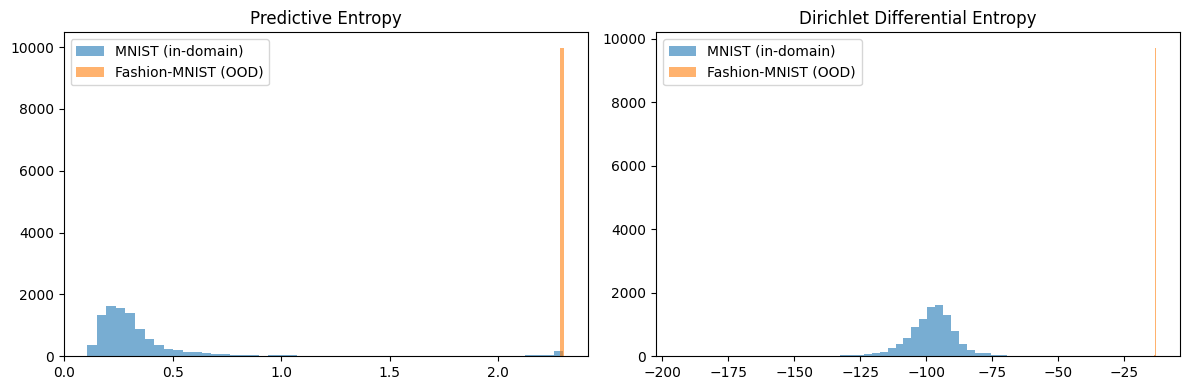

In [17]:
# Plot predictive entropy and differential entropy histograms
plt.figure(figsize=(12, 4))

# Predictive entropy histogram
plt.subplot(1, 2, 1)
plt.hist(mnist_ent, bins=50, alpha=0.6, label="MNIST (in-domain)")
plt.hist(fmnist_ent, bins=50, alpha=0.6, label="Fashion-MNIST (OOD)")
plt.title("Predictive Entropy")
plt.legend()

# Differential entropy histogram
plt.subplot(1, 2, 2)
plt.hist(mnist_dent, bins=50, alpha=0.6, label="MNIST (in-domain)")
plt.hist(fmnist_dent, bins=50, alpha=0.6, label="Fashion-MNIST (OOD)")
plt.title("Dirichlet Differential Entropy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score

# Build labels: 0 = in-domain, 1 = out-of-distribution
y_true = np.concatenate([np.zeros_like(mnist_dent), np.ones_like(fmnist_dent)])

# Use Dirichlet differential entropy as the OOD score
y_scores = np.concatenate([mnist_dent, fmnist_dent])

# Compute OOD metrics
auc = roc_auc_score(y_true, y_scores)
aupr = average_precision_score(y_true, y_scores)

print(f"OOD ROC-AUC: {auc:.4f}")
print(f"OOD PR-AUC:  {aupr:.4f}")

OOD ROC-AUC: 1.0000
OOD PR-AUC:  1.0000


# 10. Summary

You have now implemented a **Dirichlet Prior Network (DPN)** from scratch and explored its ability to model predictive uncertainty.

Here’s a quick recap of what you covered:


## 🔑 Key Takeaways!

### ✔ Classical neural networks are often overconfident  
Softmax outputs a single distribution and cannot express uncertainty properly, especially for out-of-distribution (OOD) samples.

### ✔ DPNs model *distributions over distributions*  
A Dirichlet distribution lets the model express:
- high precision → high confidence  
- low precision → uncertainty / OOD detection  

### ✔ Training requires two types of data  
- **In-domain**: sharp Dirichlet  
- **OOD**: flat Dirichlet  

### ✔ Useful uncertainty measures  
- **Predictive entropy**  
- **Dirichlet differential entropy**  
- **Precision (α₀)**  

### ✔ DPNs can detect OOD samples  
By comparing uncertainty levels between datasets.
